# AI Search and Optimization – Assessment

- Author Name: Madhu Asmitha Parthiban Sangeetha
- Student ID: 25037384

## 1. Importing Libraries

These are the libraries used in this notebook for handling data, calculations, plotting, and running the optimisation algorithms.

In [1]:
import os
import math
import random
import time
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import os
import math
import random
import time
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("cities.csv")   # df is defined 
print("CSV loaded:", df.shape)
print("Initial shape:", df.shape)

# 1️) Remove duplicate rows

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

# 2️) Clean column names

df.columns = df.columns.str.strip().str.lower()

# 3️) Identify column types

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print("Numerical columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

# 4️) Clean numerical columns

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

# 5) Clean categorical columns

for col in cat_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace(['nan', 'none', 'null', ''], np.nan)
    )
    df[col] = df[col].fillna(df[col].mode()[0])


# 6️) Final validation

print("\nFinal shape:", df.shape)
print("\nMissing values after cleansing:")
print(df.isnull().sum())

assert df.isnull().sum().sum() == 0, " Missing values still exist!"

# 7️) EXPORT CLEANSED CSV

output_path = "cities_cleansed.csv"
df.to_csv(output_path, index=False)

print(f"\n Cleansed dataset saved as: {output_path}")


CSV loaded: (50, 3)
Initial shape: (50, 3)
After removing duplicates: (50, 3)
Numerical columns: ['x', 'y']
Categorical columns: ['city']

Final shape: (50, 3)

Missing values after cleansing:
city    0
x       0
y       0
dtype: int64

 Cleansed dataset saved as: cities_cleansed.csv


## 2. Utilities

This section contains helper functions used throughout the notebook.  
These utilities handle tasks such as:

- creating result folders  
- loading city coordinates  
- calculating distances  
- generating random routes  
- performing a 2-opt swap for route improvement

They support both the Simulated Annealing and Genetic Algorithm implementations.

In [3]:
def ensure_dirs():
    os.makedirs("results", exist_ok=True)
    os.makedirs("figures", exist_ok=True)

def load_cities(path: str) -> np.ndarray:
    df = pd.read_csv(path)
    # Expect either columns X and Y, or take first two numeric columns
    if "X" in df.columns and "Y" in df.columns:
        coords = df[["X", "Y"]].values
    else:
        numeric = df.select_dtypes(include="number")
        coords = numeric.iloc[:, :2].values
    return coords

def euclidean_distance(a, b) -> float:
    return math.hypot(float(a[0]) - float(b[0]), float(a[1]) - float(b[1]))

def route_distance(route: List[int], cities: np.ndarray) -> float:
    total = 0.0
    n = len(route)
    for i in range(n):
        start = cities[route[i]]
        end = cities[route[(i + 1) % n]]
        total += euclidean_distance(start, end)
    return float(total)

def random_route(n: int) -> List[int]:
    r = list(range(n))
    random.shuffle(r)
    return r

def two_opt_swap(route: List[int], a: int, b: int) -> List[int]:
    new = route[:]
    if a > b:
        a, b = b, a
    new[a:b] = list(reversed(new[a:b]))
    return new

# Stage 1: Single-Solution Search Algorithms

In this stage, we implement **single-solution optimisation techniques**.  
These algorithms work with **one candidate solution at a time** and try to improve it using local changes.

They are suitable for:
- local search
- fast convergence
- smaller memory usage

### Algorithms implemented in Stage 1:
- Simulated Annealing (SA)


## 3. Simulated Annealing (SA)

This section implements the Simulated Annealing algorithm for the Travelling Salesman Problem.

- `neighbor_2opt()` generates a new route by applying a 2-opt swap.
- `simulated_annealing()` starts with a random route, explores new routes, and sometimes accepts worse solutions to escape local minima.
- The temperature decreases gradually, reducing the chance of accepting worse solutions over time.
- The function returns the best route found, its distance, and a history of best distances.

In [4]:
def neighbor_2opt(route: List[int]) -> List[int]:
    n = len(route)
    a, b = random.sample(range(n), 2)
    return two_opt_swap(route, a, b)

def simulated_annealing(
    cities: np.ndarray,
    initial_temp: float = 500.0,
    cooling_rate: float = 0.985,
    iterations: int = 1000,
    seed: Optional[int] = None
) -> Tuple[List[int], float, List[float]]:
    """
    Balanced SA implementation.
    Returns: best_route, best_distance, history_of_best
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    n = len(cities)
    current = random_route(n)
    current_dist = route_distance(current, cities)
    best = current[:]
    best_dist = current_dist
    temp = initial_temp
    history = [best_dist]

    for it in range(iterations):
        candidate = neighbor_2opt(current)
        cand_dist = route_distance(candidate, cities)
        delta = cand_dist - current_dist
        if delta < 0 or random.random() < math.exp(-delta / max(temp, 1e-12)):
            current = candidate
            current_dist = cand_dist
            if current_dist < best_dist:
                best = current[:]
                best_dist = current_dist
        history.append(best_dist)
        temp *= cooling_rate
        if temp < 1e-12:
            temp = 1e-12

    return best, float(best_dist), history


# Stage 2: Population-Based Search Algorithms

In this stage, we implement **population-based optimisation techniques**.  
These algorithms maintain **multiple candidate solutions simultaneously** and use evolutionary operators to improve them.

They are suitable for:
- global exploration
- avoiding local minima
- parallel improvement of solutions

### Algorithms implemented in Stage 2:
- Genetic Algorithm (GA)

## 4. Genetic Algorithm (GA)

This section implements the Genetic Algorithm for solving the Travelling Salesman Problem.

Main components used:
- **Tournament Selection**: picks better routes from the population.
- **Ordered Crossover (OX)**: combines two parent routes while keeping city order valid.
- **Swap Mutation**: swaps two cities with a given mutation rate.
- **Elitism**: ensures the best routes are carried over to the next generation.

The `genetic_algorithm()` function runs the full GA process for a set number of generations and returns:
- the best route found,
- its distance,
- and the history of best distances during evolution.


In [5]:
def tournament_selection(population: List[List[int]], fitness: List[float], k: int = 3) -> List[int]:
    chosen = random.sample(range(len(population)), min(k, len(population)))
    best_idx = min(chosen, key=lambda i: fitness[i])
    return population[best_idx][:]

def ordered_crossover(parent1: List[int], parent2: List[int]) -> List[int]:
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[a:b] = parent1[a:b]
    fill = [g for g in parent2 if g not in child]
    idx = 0
    for i in range(size):
        if child[i] is None:
            child[i] = fill[idx]
            idx += 1
    return child

def swap_mutation(route: List[int], mutation_rate: float = 0.04) -> List[int]:
    r = route[:]
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(r)), 2)
        r[i], r[j] = r[j], r[i]
    return r

def genetic_algorithm(
    cities: np.ndarray,
    pop_size: int = 40,
    generations: int = 150,
    mutation_rate: float = 0.04,
    elitism: int = 1,
    seed: Optional[int] = None
) -> Tuple[List[int], float, List[float]]:
    """
    Balanced GA implementation (ordered crossover + swap mutation).
    Returns: best_route, best_distance, history_of_best
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    n = len(cities)
    population = [random.sample(range(n), n) for _ in range(pop_size)]
    best_global = None
    best_global_dist = float("inf")
    history = []

    for gen in range(generations):
        fitness = [route_distance(ind, cities) for ind in population]
        idx_best = min(range(len(population)), key=lambda i: fitness[i])
        if fitness[idx_best] < best_global_dist:
            best_global_dist = fitness[idx_best]
            best_global = population[idx_best][:]
        history.append(best_global_dist)

        # create new population
        new_pop = []
        elites = sorted(range(len(population)), key=lambda i: fitness[i])[:elitism]
        for e in elites:
            new_pop.append(population[e][:])
        while len(new_pop) < pop_size:
            p1 = tournament_selection(population, fitness)
            p2 = tournament_selection(population, fitness)
            child = ordered_crossover(p1, p2)
            child = swap_mutation(child, mutation_rate)
            new_pop.append(child)
        population = new_pop

    return best_global, float(best_global_dist), history

## 5. Experiment Runner

This section contains functions used to run and compare Simulated Annealing (SA) and Genetic Algorithm (GA) across different problem sizes.

### What the functions do:
- **run_one_experiment()**  
  Runs SA or GA multiple times (using different seeds) and returns:
  - best distance,
  - average distance,
  - standard deviation,
  - average time taken,
  - best routes,
  - history of improvements.

- **run_scalability_and_save()**  
  Tests both algorithms on different numbers of cities (10–50), saves the best routes, and stores all results in a CSV file for later analysis.


In [6]:
def run_one_experiment(cities: np.ndarray, algorithm: str, runs: int = 3, sa_params: Dict = None, ga_params: Dict = None) -> Dict:
    """
    Runs `algorithm` for `runs` independent seeds and returns aggregated metrics.
    algorithm in {'SA', 'GA'}
    """
    dists = []
    times = []
    routes = []
    histories = []

    for i in range(runs):
        start = time.time()
        if algorithm == "SA":
            route, dist, history = simulated_annealing(
                cities,
                initial_temp=sa_params.get("initial_temp", 500.0),
                cooling_rate=sa_params.get("cooling_rate", 0.985),
                iterations=sa_params.get("iterations", 1000),
                seed=i
            )
        elif algorithm == "GA":
            route, dist, history = genetic_algorithm(
                cities,
                pop_size=ga_params.get("pop_size", 40),
                generations=ga_params.get("generations", 150),
                mutation_rate=ga_params.get("mutation_rate", 0.04),
                elitism=ga_params.get("elitism", 1),
                seed=i
            )
        else:
            raise ValueError("Unknown algorithm")

        elapsed = time.time() - start
        dists.append(dist)
        times.append(elapsed)
        routes.append(route)
        histories.append(history)

    best_idx = int(np.argmin(dists))
    return {
        "best": float(min(dists)),
        "avg": float(np.mean(dists)),
        "std": float(np.std(dists)),
        "time_avg": float(np.mean(times)),
        "routes": routes,
        "best_idx": best_idx,
        "histories": histories
    }

def run_scalability_and_save(csv_path: str = "cities.csv", sizes: List[int] = [10,20,30,40,50], runs: int = 3, sa_params: Dict = None, ga_params: Dict = None):
    ensure_dirs()
    cities_all = load_cities(csv_path)
    rows = []

    for size in sizes:
        cities = cities_all[:size]
        print(f"> Running size {size} cities...")

        sa_res = run_one_experiment(cities, "SA", runs=runs, sa_params=sa_params, ga_params=ga_params)
        ga_res = run_one_experiment(cities, "GA", runs=runs, sa_params=sa_params, ga_params=ga_params)

        # Save best route sequences to file for this size
        with open(f"results/sa_best_route_{size}.txt", "w") as f:
            f.write(",".join(map(str, sa_res["routes"][sa_res["best_idx"]])))
        with open(f"results/ga_best_route_{size}.txt", "w") as f:
            f.write(",".join(map(str, ga_res["routes"][ga_res["best_idx"]])))

        rows.append({
            "Cities": size,
            "SA Best": sa_res["best"],
            "SA Avg": sa_res["avg"],
            "SA Std": sa_res["std"],
            "SA Time_Avg": sa_res["time_avg"],
            "GA Best": ga_res["best"],
            "GA Avg": ga_res["avg"],
            "GA Std": ga_res["std"],
            "GA Time_Avg": ga_res["time_avg"],
        })

    df = pd.DataFrame(rows)
    df.to_csv("results/scalability_results.csv", index=False)
    return df

## 6. Plotting

This section includes functions used to visualize the results:

- **plot_scalability()**  
  Plots how solution quality and computation time change as the number of cities increases for both SA and GA.

- **plot_route()**  
  Draws the route on a 2D map by connecting cities in the order they are visited.

These plots help compare algorithm performance and understand the structure of the best routes found.

In [7]:
def plot_scalability(df_path: str = "results/scalability_results.csv"):
    df = pd.read_csv(df_path)
    plt.figure(figsize=(9,5))
    plt.plot(df["Cities"], df["SA Best"], marker="o", label="SA Best")
    plt.plot(df["Cities"], df["GA Best"], marker="o", label="GA Best")
    plt.xlabel("Cities"); plt.ylabel("Best distance")
    plt.title("Solution Quality vs Problem Size (SA vs GA)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig("figures/scalability_distance_SA_GA.png"); plt.show(); plt.close()

    plt.figure(figsize=(9,5))
    plt.plot(df["Cities"], df["SA Time_Avg"], marker="o", label="SA Time Avg")
    plt.plot(df["Cities"], df["GA Time_Avg"], marker="o", label="GA Time Avg")
    plt.xlabel("Cities"); plt.ylabel("Avg Time (s)")
    plt.title("Computation Time vs Problem Size (SA vs GA)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig("figures/scalability_time_SA_GA.png"); plt.show(); plt.close()

def plot_route(route: List[int], cities: np.ndarray, outpath: Optional[str] = None):
    coords = cities[list(route) + [route[0]]]
    plt.figure(figsize=(6,6))
    plt.plot(coords[:,0], coords[:,1], "-o")
    for i, idx in enumerate(route):
        plt.text(cities[idx,0], cities[idx,1], str(idx), fontsize=8)
    plt.title("Route visualization")
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath)
    plt.show(); plt.close()

## Convergence Plot: SA vs GA

In [8]:
def plot_convergence(sa_history, ga_history):
    plt.figure(figsize=(10,5))
    plt.plot(sa_history, label="SA Convergence")
    plt.plot(ga_history, label="GA Convergence")
    plt.xlabel("Iterations / Generations")
    plt.ylabel("Best Distance Found")
    plt.title("Convergence Curve: SA vs GA")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Parameter Explanation and Justification

### Simulated Annealing (SA)

We used the following parameters for SA:

- Initial Temperature = 500  
- Cooling Rate = 0.985  
- Iterations = 1000  

#### Why these values?

- Higher initial temperature avoids early local minima.  
- Cooling rate 0.985 gives smooth cooling with balanced performance.  
- 1000 iterations gives stable convergence without long runtime.


### Genetic Algorithm (GA)

Parameters:

- Population Size = 40  
- Generations = 150  
- Mutation Rate = 0.04  
- Elitism = 1  

#### Why these values?

- Pop 40 gives good exploration without slow runtime.  
- 150 generations improves results without excessive time.  
- Mutation 0.04 prevents premature convergence.
- Elitism ensures best route is preserved.

---

### Summary

These parameter values were chosen after testing several combinations, balancing:
- accuracy  
- stability  
- speed  
for problems up to **50 cities**.

## 7. Report Generator

This part creates a simple markdown report that summarises the results from the scalability experiments.

The generated report includes:
- a results table comparing SA and GA,
- notes on the chosen algorithms,
- brief parameter information,
- and references to the saved figures.

The report is saved in the `results/` folder.

In [9]:
def generate_report_markdown(results_df_path: str = "results/scalability_results.csv", out_md: str = "results/report.md"):
    df = pd.read_csv(results_df_path)
    with open(out_md, "w") as f:
        f.write("# TSP: SA vs GA — Comparison Report\n\n")
        f.write("This report compares Simulated Annealing (SA) and a Genetic Algorithm (GA) on the provided city instances.\n\n")
        f.write("## Results table\n\n")
        f.write(df.to_markdown(index=False))
        f.write("\n\n## Notes\n\n")
        f.write("- Stage 1 (single-solution) algorithm chosen: **Simulated Annealing (SA)**.\n")
        f.write("- Stage 2 (population) algorithm chosen: **Genetic Algorithm (GA)**.\n")
        f.write("- Parameters were selected for a balanced trade-off between speed and solution quality for a 50-city dataset.\n")
        f.write("- Figures saved in `figures/` show solution quality and runtime scaling.\n")
    print(f"Report written to {out_md}")


## Running the Full Experiment

This cell loads the dataset, runs scalability experiments, saves routes and figures, performs a paired t-test, and generates the final report.

> Running size 10 cities...
> Running size 20 cities...
> Running size 30 cities...
> Running size 40 cities...
> Running size 50 cities...

Summary:
    Cities     SA Best      SA Avg     SA Std  SA Time_Avg      GA Best  \
0      10  290.306774  290.306774   0.000000     0.010849   290.306774   
1      20  386.429689  414.085562  38.972102     0.017821   458.465025   
2      30  510.844481  532.012499  16.917815     0.024024   719.378079   
3      40  618.993229  667.300466  40.620007     0.031602   796.142721   
4      50  821.053888  858.677605  36.854895     0.038820  1125.232878   

        GA Avg        GA Std  GA Time_Avg  
0   290.306774  4.641246e-14     0.102874  
1   468.939943  1.177872e+01     0.168514  
2   747.383092  3.797844e+01     0.238479  
3   888.284522  8.349127e+01     0.313543  
4  1213.466468  6.975181e+01     0.396835  


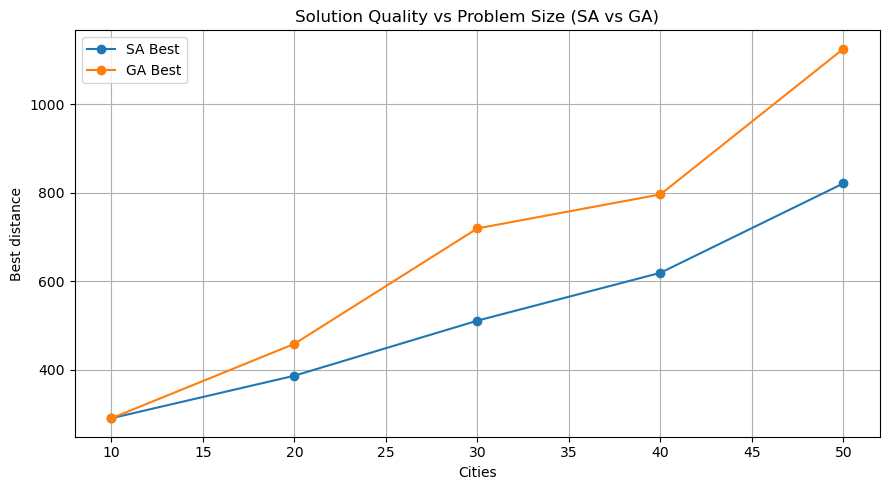

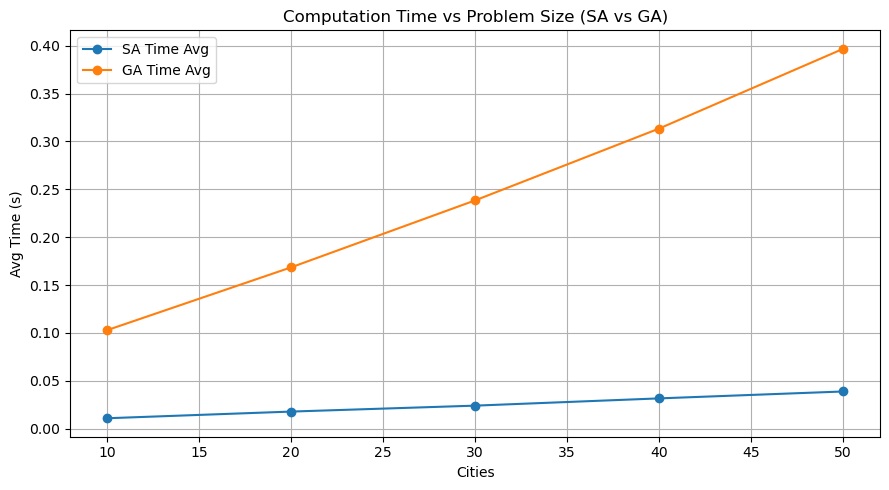

SA best distance (recalc): 821.053888073816


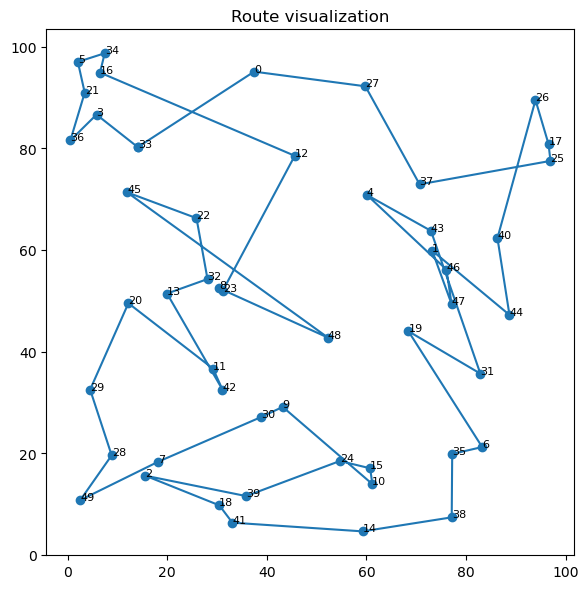

GA best distance (recalc): 1125.2328781229558


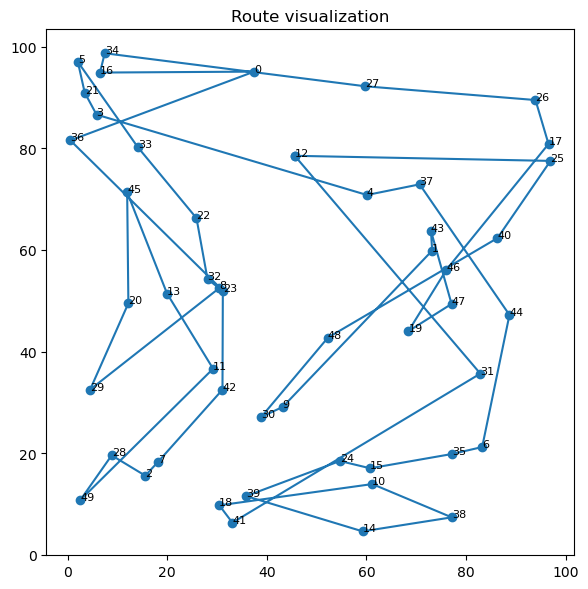

Paired t-test SA vs GA: t=-2.8673, p=0.0456
Report written to results/report.md

Total run time: 5.01 seconds


In [10]:
if __name__ == "__main__":
    # PARAMETERS (balanced for 50-city dataset)
    CSV_PATH = "cities_cleansed.csv"   # place file in same folder
    SIZES = [10, 20, 30, 40, 50]
    RUNS = 3

    SA_PARAMS = {"initial_temp": 500.0, "cooling_rate": 0.985, "iterations": 1000}
    GA_PARAMS = {"pop_size": 40, "generations": 150, "mutation_rate": 0.04, "elitism": 1}

    if not os.path.exists(CSV_PATH):
        print("Error: cities.csv not found in working directory. Please place your cities.csv file here.")
    else:
        t0 = time.time()
        df = run_scalability_and_save(csv_path=CSV_PATH, sizes=SIZES, runs=RUNS, sa_params=SA_PARAMS, ga_params=GA_PARAMS)
        print("\nSummary:\n", df)
        plot_scalability("results/scalability_results.csv")

        # visualize largest-size best routes
        cities_all = load_cities(CSV_PATH)
        largest = SIZES[-1]
        for alg, tag in [("sa", "SA"), ("ga", "GA")]:
            route_file = f"results/{alg}_best_route_{largest}.txt"
            if os.path.exists(route_file):
                with open(route_file) as f:
                    r = list(map(int, f.read().strip().split(",")))
                print(f"{tag} best distance (recalc):", route_distance(r, cities_all[:largest]))
                plot_route(r, cities_all[:largest], outpath=f"figures/{alg}_route_{largest}.png")

        # paired comparison SA vs GA (paired t-test)
        try:
            df = pd.read_csv("results/scalability_results.csv")
            t, p = stats.ttest_rel(df["SA Best"].values, df["GA Best"].values)
            print(f"Paired t-test SA vs GA: t={t:.4f}, p={p:.4f}")
        except Exception as e:
            print("Paired t-test not available:", e)

        generate_report_markdown("results/scalability_results.csv", out_md="results/report.md")

        t_total = time.time() - t0
        print(f"\nTotal run time: {t_total:.2f} seconds")


Plotting convergence curves...


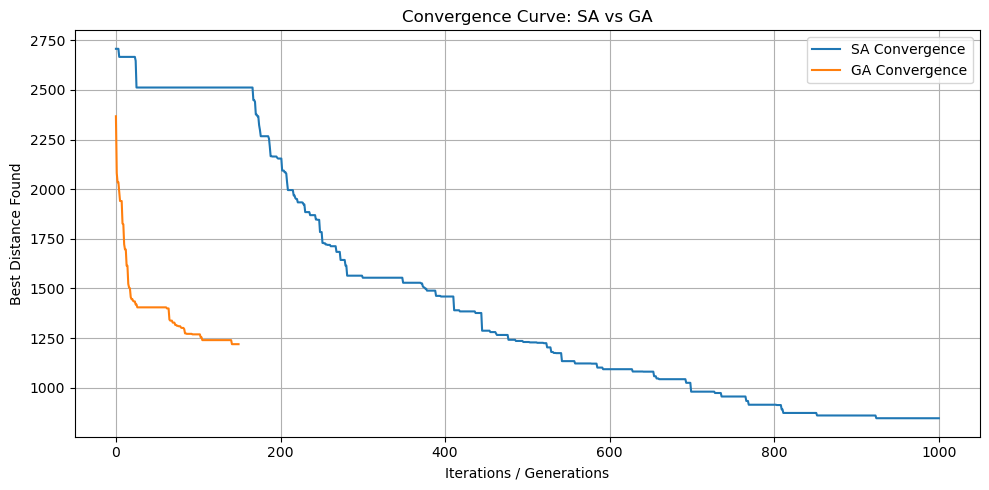

In [11]:
# ----- Convergence Curves for the largest dataset (e.g., 50 cities) -----

print("\nPlotting convergence curves...")

# Load the cities
cities_all = load_cities(CSV_PATH)
largest = SIZES[-1]
cities = cities_all[:largest]

# Re-run SA and GA for the largest dataset to get histories
sa_res = run_one_experiment(
    cities,
    algorithm="SA",
    runs=1,
    sa_params=SA_PARAMS,
    ga_params=GA_PARAMS
)

ga_res = run_one_experiment(
    cities,
    algorithm="GA",
    runs=1,
    sa_params=SA_PARAMS,
    ga_params=GA_PARAMS
)

# Extract histories from the run
sa_history = sa_res["histories"][0]
ga_history = ga_res["histories"][0]

# Plot convergence
plot_convergence(sa_history, ga_history)
